## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 17: Convnets in Practice - Notebook 2: Images

In [1]:
import keras
import cv2, numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Just in case the Keras defaults aren't as we expect
from keras import backend as K_backend
K_backend.set_image_data_format('channels_last')

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
# The output of the VGG16 model is a little complicated. Each of the
# 1000 outputs contains an index number and the associated score
# of the prediction for that index. This index is the location of
# the entry in the array syn_indices_list defined in syn_indices.py.
# Those entries are strings. The index number is the line of the
# file (or the index into that array). Then we use that string
# as the key in a dictionary syn_words_dict stored in syn_words,
# and the value of that dictionary item is the descriptive string
# for that entry. These two files are just slightly python-ized
# versions of syn_indices.txt and syn_words.txt, available from 
# the original VGG16 Caffe source at 
# http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz 

input_dir = file_helper.get_input_data_dir()
sys.path.append(input_dir)


# Use the VGG16 model (and correctly formatted weights!) from Keras
from keras.applications.vgg16 import VGG16
model = VGG16()

In [5]:
from input_data import VGG16_syn_indices, VGG16_syn_words


def categorize_image(img, top_number):
    # Read in the image, and then jiggle it around to get it into
    # the expected input format. Images may stored at any size,
    # but they should be square to avoid stretching before classification.
    # First, we subtract from each component so the pixels have a 
    # zero mean. We must do this because this transformation was
    # used when the VGG16 network was trained. There were no other
    # data transformations applied.
    # Next, we shuffle the color order. CV2 stores a picture in BGR 
    # order, and VGG16 seems to wang RBG (neither one the conventional 
    # RGB order). There must be a CV2 function to shuffle the channels,
    # but I couldn't find it, so I just do it manually.
    # Then we stick an extra dimension of size 1 at the start of the
    # image's shape to make the single image look like a batch of
    # images, but the batch is just this one image.
    
    image = cv2.resize(cv2.imread(img), (224, 224)).astype(np.float32)
    blu = image[:,:,0].copy()
    grn = image[:,:,1].copy()
    red = image[:,:,2].copy()
    blu -= 103.939  # These numbers were used for the training data
    grn -= 116.779  # used for VGG16, so we must use them, too. See 
    red -= 123.68   # https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
    image[:,:,0] = red
    image[:,:,1] = blu
    image[:,:,2] = grn

    image = np.array([image])  # make it a list of 1 image
    
    predictions = model.predict(image)[0]
    top_list = []
    for i in range(top_number):
        maxarg = np.argmax(predictions)
        maxval = predictions[maxarg]
        top_list.append([maxarg, maxval])
        predictions = [i if i<maxval else -1 for i in predictions]
    report_scores = []
    report_names = []
    for i in top_list:
        n_index = VGG16_syn_indices.syn_indices_list[i[0]]
        words = VGG16_syn_words.syn_words_dict[n_index]
        words = words[:16]  # clip to first 16 chars
        report_scores.append(i[1])
        report_names.append(words)
    return (report_scores, report_names)

In [6]:
def report_figure(figure_set, filename):
    num_labels = 5
    (report_scores, report_names) = categorize_image(figure_set['path'], num_labels) 
    report_names = [f.split(',')[0] for f in report_names]
    fig = plt.figure(figsize=(8,3))
    fig.subplots_adjust(wspace=0.0)
    plt.subplot(1,2,1)
    img = plt.imread(figure_set['path'])
    plt.imshow(img)
    #plt.xlabel(str(figure_set['label']))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(1,2,2)
    xs = range(len(report_names))
    plt.bar(xs, report_scores, align='center')
    plt.xticks(xs, report_names, rotation='-90')
    plt.yticks([0,1],[0,1])
    plt.tick_params(axis='x', which='major', labelsize=18)   
    file_helper.save_figure(figure_set['saveas']+'-scores')
    plt.show()

In [7]:
def four_up_figure(figure_sets, save_name):
    num_labels = 5
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        if not figure_sets[i]:
            continue
        (report_scores, report_names) = categorize_image(figure_sets[i]['path'], num_labels) 
        report_names = [f.split(',')[0] for f in report_names]
        fig.subplots_adjust(wspace=0.0)
        fig.subplots_adjust(hspace=0.75)
        img = plt.imread(figure_sets[i]['path'])
        ax0 = plt.subplot(2, 4, 1+(2*i))
        ax0.imshow(img)
        plt.xticks([],[])
        plt.yticks([],[])
        ax1 = plt.subplot(2, 4, 2+(2*i))
        xs = range(len(report_names))
        ax1.bar(xs, report_scores, align='center')
        plt.xticks(xs, report_names, rotation=-90)
        plt.yticks([0,1], [0,1])
        plt.tick_params(axis='x', which='major', labelsize=12)
        file_helper.save_figure(save_name)
    plt.show()

In [8]:
def get_image_fig_sets():
    input_dir = file_helper.get_input_data_dir()
    image_fig_sets = [
        { 'label':'car', 'path':input_dir+'/img.jpg', 'saveas':'car'},
        { 'label':'table-base', 'path':input_dir+'/table-base.jpg', 'saveas':'table-base'},
        { 'label':'table', 'path':input_dir+'/table.jpg', 'saveas':'table'},
        { 'label':'labrador', 'path':input_dir+'/labrador.jpg', 'saveas':'labrador'},
        ]
    return image_fig_sets

In [9]:
image_fig_sets = get_image_fig_sets()

In [10]:
def draw_all_fig_sets(fig_sets):
    save_result = False
    for fig_set in fig_sets:
        report_figure(fig_set, save_result)

In [11]:
def draw_four_ups(fig_sets, save_prefix):
    save_result = False
    i = 0
    setnum = 1
    while i < len(fig_sets):
        fig_list = [None]*4
        for v in range(4):
            if i < len(fig_sets):
                fig_list[v] = fig_sets[i]
            i += 1
        print("\n\n")
        four_up_figure(fig_list, save_prefix+'-4-up-'+str(setnum))
        setnum += 1




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


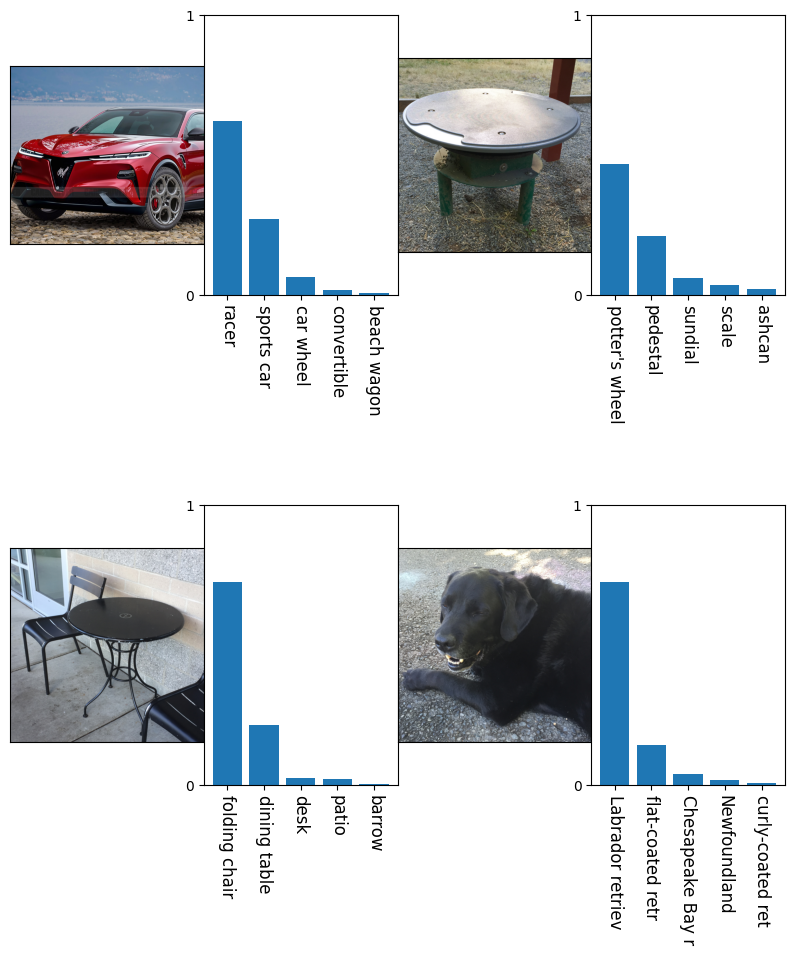

In [12]:
draw_four_ups(image_fig_sets, 'imageset')